# Neural Style Transfer

## Importing dependencies

In [0]:
import numpy as np
from keras.applications import vgg19
from keras import backend as K
from keras.preprocessing.image import load_img, img_to_array
from scipy.optimize import fmin_l_bfgs_b
from scipy.misc import imsave, imresize
from IPython.display import Image

In [0]:
BASE_IMAGE = 'base_image.jpeg'
STYLE_IMAGE = 'style_image.jpeg'
height = 400
width = 500

## Base Image we will be working with

In [0]:
def preprocess_image(image_path):
    img = load_img(image_path, target_size=(height, width))
    img = img_to_array(img)
    img = np.expand_dims(img, axis=0)
    img = vgg19.preprocess_input(img)
    return img

In [0]:
def deprocess_image(x):
    if K.image_data_format() == 'channels_first':
        x = x.reshape((3, height, width))
        x = x.transpose((1, 2, 0))
    else:
        x = x.reshape((height, width, 3))
    # Remove zero-center by mean pixel
    x[:, :, 0] += 103.939
    x[:, :, 1] += 116.779
    x[:, :, 2] += 123.68
    # 'BGR'->'RGB'
    x = x[:, :, ::-1]
    x = np.clip(x, 0, 255).astype('uint8')
    return x

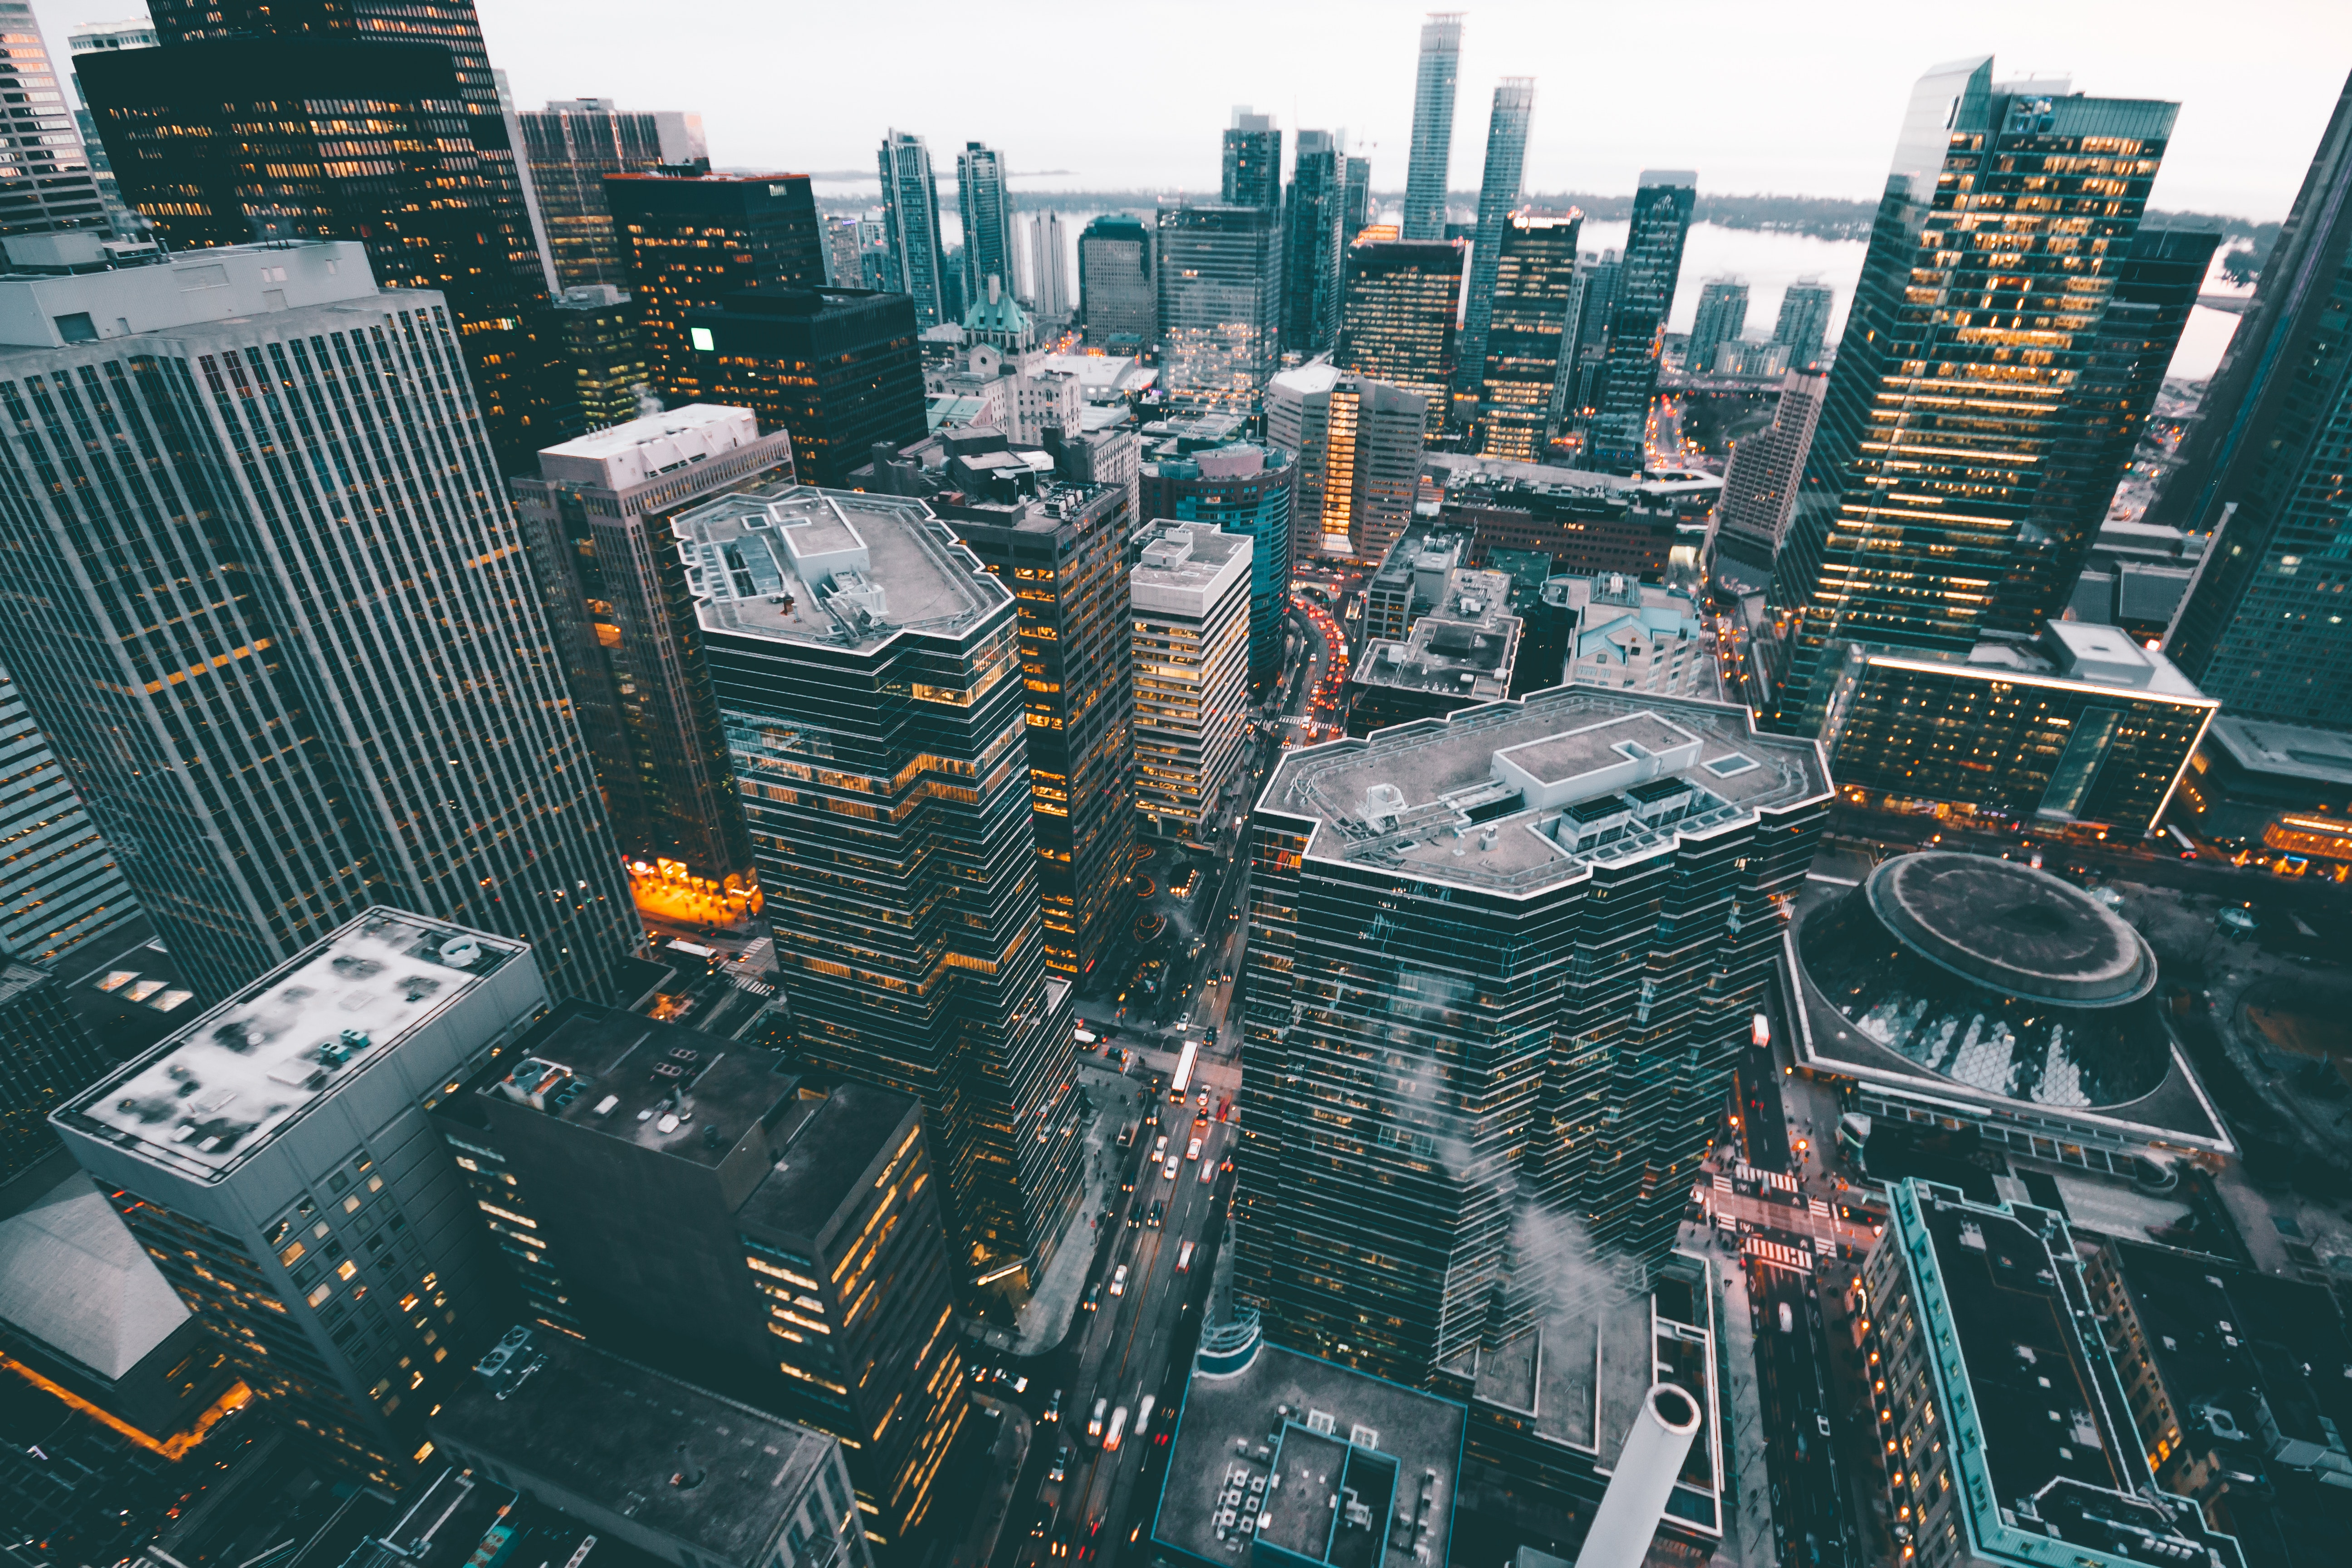

In [136]:
Image(BASE_IMAGE)

## Style Image we will be working with

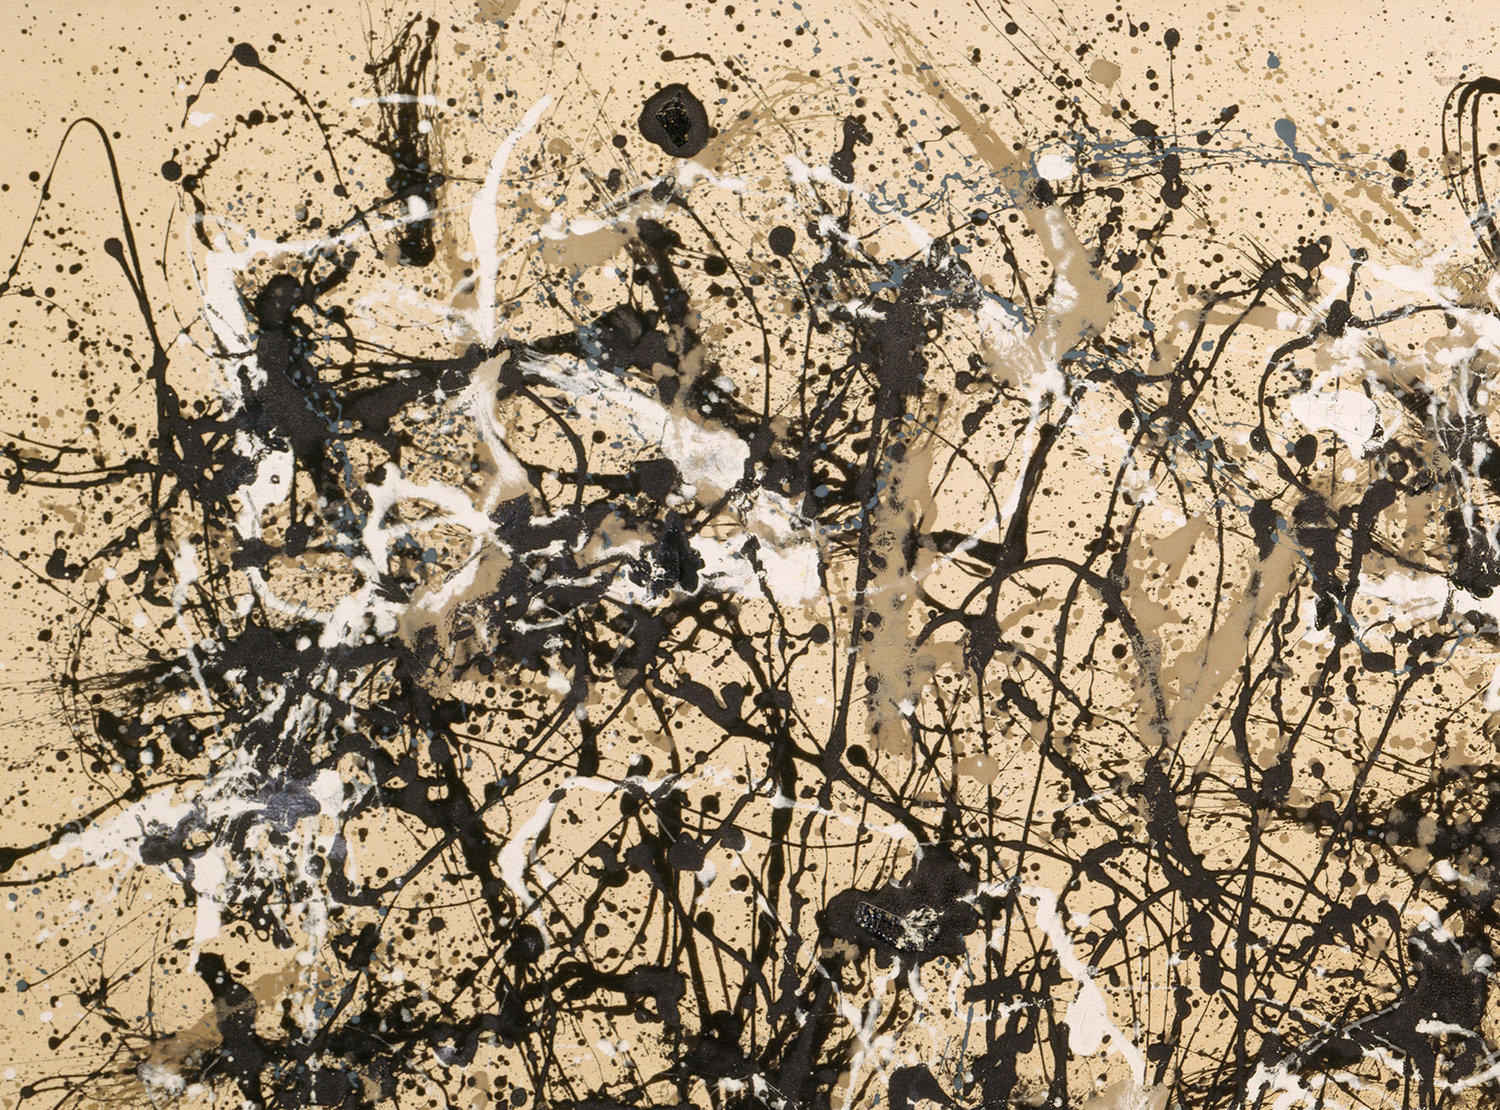

In [137]:
Image(STYLE_IMAGE)

## Tensor representations of images

In [0]:
base_image = K.variable(preprocess_image(BASE_IMAGE))
style_image = K.variable(preprocess_image(STYLE_IMAGE))
generated_image = K.placeholder(shape=(1, height, width, 3))

## Combine 3 images into a single keras tensor

In [0]:
input_tensor = K.concatenate([base_image, style_image, generated_image], axis=0)

# Build the VGG19 model with 3 images as input

In [140]:
model = vgg19.VGG19(input_tensor = input_tensor, weights = 'imagenet', include_top = False)
print("Loaded model successfully")

Loaded model successfully


In [0]:
outputs_dict = dict([(layer.name, layer.output) for layer in model.layers])

In [142]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_5 (InputLayer)         (None, None, None, 3)     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, None, None, 64)    1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, None, None, 64)    36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, None, None, 64)    0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, None, None, 128)   73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, None, None, 128)   147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, None, None, 128)   0         
__________

## Content Loss

In [0]:
def content_loss(base, gen):
    return K.sum(K.square(gen - base))

In [0]:
CONTENT_WEIGHT = 0.025
STYLE_WEIGHT = 1.0
TOTAL_VARIATION_WEIGHT = 1.0

In [0]:
loss = 0.
layer_features = outputs_dict['block5_conv2']
base_image_features = layer_features[0, :, :, :]
generated_image_features = layer_features[2, :, :, :]
loss += CONTENT_WEIGHT * content_loss(base_image_features, generated_image_features)

## Gram Matrix

In [0]:
def gram_matrix(x):
    assert K.ndim(x) == 3
    features = K.batch_flatten(K.permute_dimensions(x, (2, 0, 1)))
    gram = K.dot(features, K.transpose(features))
    return gram

## Style Loss

In [0]:
def style_loss(style, gen):
    assert K.ndim(style) == 3
    assert K.ndim(gen) == 3
    S = gram_matrix(style)
    G = gram_matrix(gen)
    channels = 3
    size = height * width
    return K.sum(K.square(S - G)) / (4. * (channels ** 2) * (size ** 2))

In [0]:
feature_layer_names = ['block1_conv1', 'block2_conv1', 'block3_conv1', 'block4_conv1', 'block5_conv1']
for name in feature_layer_names:
    layer_features = outputs_dict[name]
    style_features = layer_features[1, :, :, :]
    gen_img_features = layer_features[2, :, :, :]
    s1 = style_loss(style_features, gen_img_features)
    loss += (STYLE_WEIGHT / len(feature_layer_names)) * s1

## Total variation loss

In [0]:
def total_variation_loss(x):
    assert K.ndim(x) == 4
    a = K.square(x[:, :height - 1, :width - 1, :] - x[:, 1:, :width - 1, :])
    b = K.square(x[:, :height - 1, :width - 1, :] - x[:, :height - 1, 1:, :])
    return K.sum(K.pow(a + b, 1.25))

In [0]:
loss += TOTAL_VARIATION_WEIGHT * total_variation_loss(generated_image)

## Evaluating the gradients

In [0]:
grads = K.gradients(loss, generated_image)

In [0]:
outputs = [loss]
if isinstance(grads, (list, tuple)):
    outputs += grads
else:
    outputs.append(grads)

In [0]:
f_output = K.function([generated_image], outputs)

## Evaluating loss and gradients

In [0]:
def eval_loss_and_grads(x):
    x = x.reshape((1, height, width, 3))
    outs = f_output([x])
    loss_value = outs[0]
    if len(outs[1:]) == 1:
        grad_values = outs[1].flatten().astype('float64')
    else:
        grad_values = np.array(outs[1:]).flatten().astype('float64')
    return loss_value, grad_values

## Evaluator class

In [0]:
class Evaluator(object):
    def __init__(self):
        self.loss_value = None
        self.grads_value = None
        self.i = 0

    def loss(self, x):
        assert self.loss_value is None
        loss_value, grad_value = eval_loss_and_grads(x)
        self.loss_value = loss_value
        self.grads_value = grad_value
        print("Iteration "+str(self.i)+" : Loss - "+str(self.loss_value))
        self.i += 1
        return self.loss_value

    def grads(self, x):
        assert self.loss_value is not None
        grads_values = np.copy(self.grads_value)
        self.loss_value = None
        self.grads_value = None
        return grads_values

## Optimization

In [0]:
evaluator = Evaluator()

In [157]:
x = preprocess_image(BASE_IMAGE)

x, min_val, info = fmin_l_bfgs_b(evaluator.loss, x.flatten(), fprime=evaluator.grads, maxiter=2000)
print('   loss: {}'.format(min_val))

img = deprocess_image(x)

imsave('output.jpg', img)

Iteration 0 : Loss - 149385270000.0
Iteration 1 : Loss - 149354710000.0
Iteration 2 : Loss - 149232580000.0
Iteration 3 : Loss - 148745340000.0
Iteration 4 : Loss - 146824230000.0
Iteration 5 : Loss - 139732570000.0
Iteration 6 : Loss - 94868630000.0
Iteration 7 : Loss - 75672860000.0
Iteration 8 : Loss - 63162660000.0
Iteration 9 : Loss - 51486400000.0
Iteration 10 : Loss - 43278600000.0
Iteration 11 : Loss - 37117714000.0
Iteration 12 : Loss - 31888101000.0
Iteration 13 : Loss - 27431100000.0
Iteration 14 : Loss - 23585800000.0
Iteration 15 : Loss - 20737389000.0
Iteration 16 : Loss - 19245943000.0
Iteration 17 : Loss - 17884242000.0
Iteration 18 : Loss - 17118787000.0
Iteration 19 : Loss - 16423784000.0
Iteration 20 : Loss - 15468691000.0
Iteration 21 : Loss - 14883897000.0
Iteration 22 : Loss - 14167264000.0
Iteration 23 : Loss - 13949602000.0
Iteration 24 : Loss - 13568601000.0
Iteration 25 : Loss - 13215914000.0
Iteration 26 : Loss - 12858491000.0
Iteration 27 : Loss - 1235527700

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:8: DeprecationWarning: `imsave` is deprecated!
`imsave` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imwrite`` instead.
  


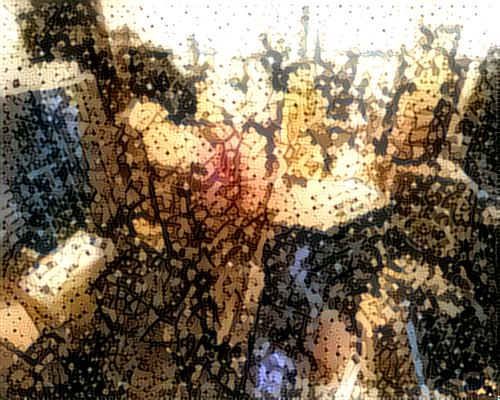

In [158]:
Image('output.jpg')